In [1]:
# try construct a set of true params: 

import numpy as np
import matplotlib.pyplot as plt

a_true = 2.50
b_true = -1.80
c_true = 3.20
f_true = 0.534

In [2]:
# generate synthetic data from model
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 3 + 15 * np.random.rand(N)
y = a_true * x**2 + b_true * x + c_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)


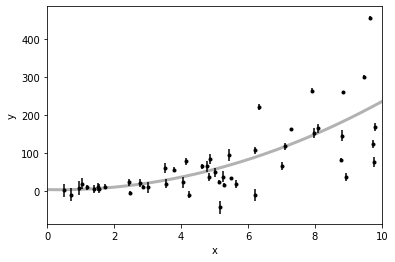

In [3]:
# plot and examine distribution
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, a_true * x0**2 + b_true * x0 + c_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [4]:
# try use the original likelihood in linear
def log_likelihood(theta, x, y, yerr):
    a, b, c, log_f = theta
    model = a * x**2 + b * x + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

       2
2.609 x - 3.941 x + 5.55


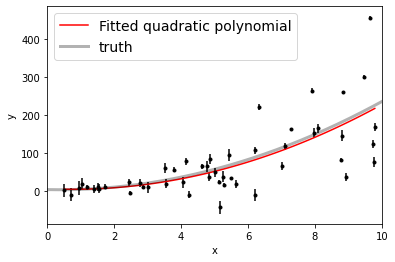

In [5]:
# polynormal estimates
degree = 2
coefficients = np.polyfit(x, y, degree)
p = np.poly1d(coefficients)
x_values = np.linspace(x[0], x[-1], 100)
y_values = p(x_values)

print(p)

plt.plot(x_values, y_values, 'r', label='Fitted quadratic polynomial')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, a_true * x0**2 + b_true * x0 + c_true, "k", alpha=0.3, lw=3, label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Maximum likelihood estimates:
a = 2.212
b = -1.135
c = 2.743
f = 0.710


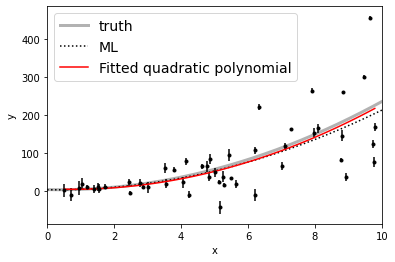

In [6]:
# try same max likelihood est. 

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([a_true, b_true, c_true, np.log(f_true)]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(x, y, yerr))
a_ml, b_ml, c_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("b = {0:.3f}".format(b_ml))
print("c = {0:.3f}".format(c_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, a_true * x0**2 + b_true * x0 + c_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 3), [a_ml, b_ml, c_ml]), ":k", label="ML")
plt.plot(x_values, y_values, 'r', label='Fitted quadratic polynomial')

plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [7]:
# looks good so far
# after listing functions of prior, posterior and likelihood...

In [8]:
# construct uniform priors on unifor a, b, c and log_f
def log_prior(theta):
    a, b, c, log_f = theta
    if -1.0 < a < 5.0 and -10.0 < b < 5.0 and -5.0 < c < 5.0 and -10.0 < log_f < 1.0 :
        return 0.0
    return -np.inf

In [9]:
# construct probability from prior and likelihood
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [10]:
# initialize 32 walkers around Gaussian aera around maximun likelihood, run 5000 steps
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 4) #note dimension is now 4
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:15<00:00, 331.96it/s]


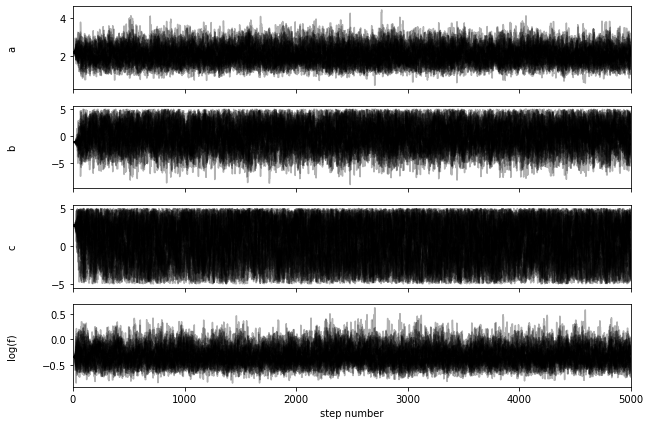

In [11]:
# check chain
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [12]:
# why it looks like this? wierd. 
# looks like its not burned-in at all

# hooray! after adding restraints on param 'c'(i stupidly forgot), and restarting the kernel, it worked like magic.

# what?? this time(after restarting the kernel) it went all wrong again and required remove ('and -1.0 < c < 5.0') in prior

# well looks like it happens when a value picked zero and all went wrong. just try more times. 

In [13]:
# examine burn-in time
tau = sampler.get_autocorr_time()
print(tau)

[51.56145952 52.8244474  55.58860218 52.40773815]


In [14]:
# apply burn-in discard and thin-in, acquire the final samples. 
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 4)


a_true = 2.5
b_true = -1.8
c_true = 3.2
f_true = 0.534


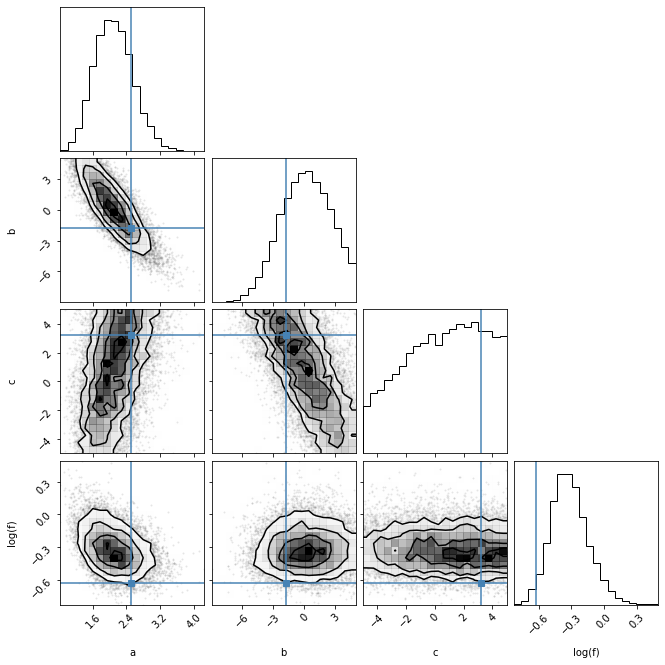

In [15]:
# lets do the corner plot. 
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[a_true, b_true, c_true, np.log(f_true)]
);

print("a_true =", a_true)
print("b_true =", b_true)
print("c_true =", c_true)
print("f_true =", f_true)

In [16]:
# result looks messy? 
# actually how to display the max posterior density? 

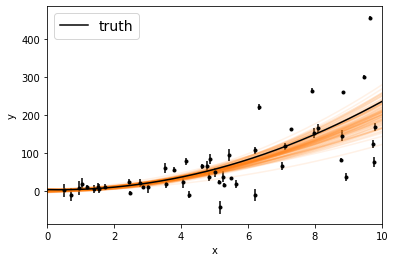

In [17]:
# diagnostic by projection onto observed data. 

from numpy import poly1d

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    a, b, c = sample[0], sample[1], sample[2]
    plt.plot(x0, a* x0**2 + b* x0 + c , "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, a_true * x0**2 + b_true * x0 + c_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [18]:
# quite good outcome, I suppose this test is done! 